In [1]:
import itertools
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats as ss
import seaborn as sns

from os import listdir
from tqdm import tqdm


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

# Load data

## Official (previous) data

In [3]:
df_llm = pd.read_csv("../../data/official/llm/glasgow_gpt-4.csv")
df_llm.head(5)

,word,AoA,Arousal,Concreteness,Dominance,Familiarity,Gender,Imageability,Size,Valence
0,Apple (brand),8.0,5.0,3.0,5.0,7.0,4.0,5.0,6.0,7.0
1,address (postal),6.0,2.0,5.0,3.0,6.0,4.0,4.0,3.0,5.0
2,address (speak to),7.0,5.0,3.0,4.0,5.0,4.0,4.0,4.0,5.0
3,aim (objective),6.0,4.0,2.0,4.0,6.0,4.0,4.0,4.0,5.0
4,aim (target),6.0,5.0,5.0,4.0,6.0,4.0,6.0,4.0,5.0


In [4]:
df_official_human = pd.read_csv("../../data/official/human/glasgow.csv")
df_official_human.head(5)

,word,Length,Arousal.M,Arousal.SD,Arousal.N,Valence.M,Valence.SD,Valence.N,Dominance.M,Dominance.SD,...,Familiarity.N,AoA.M,AoA.SD,AoA.N,Size.M,Size.SD,Size.N,Gender.M,Gender.SD,Gender.N
0,address (postal),7,3.546,1.940,33,5.000,0.739,33,5.114,1.489,...,32,3.059,1.056,34,3.471,1.419,34,4.000,0.612,32
1,address (speak to),7,4.000,2.029,34,5.559,1.063,34,6.182,2.066,...,35,4.800,1.090,35,4.171,1.502,35,3.824,0.954,34
2,aim (objective),3,4.909,2.340,33,6.382,1.189,34,5.909,2.021,...,33,4.529,1.334,34,4.500,1.399,34,4.235,1.086,34
3,aim (target),3,5.200,2.214,35,5.600,1.642,35,6.714,1.631,...,33,3.618,1.534,34,3.686,1.617,35,4.743,1.104,35
4,Apple (brand),5,4.849,2.687,33,5.971,1.902,34,4.600,2.440,...,34,6.000,1.553,34,5.353,1.954,34,4.647,1.210,34


## New data

In [5]:
df = pd.read_csv("../../data/processed/glasgow_concreteness.csv")
print(str(len(set(df['participant']))) + " ppts collected.")

195 ppts collected.


### Exclude ppts who failed catch trials

In [6]:
### Catch trials
df_catch = df[df['catch_trial'] == True]
df_catch['correct'] = df_catch['Response'] == 1
exclude = df_catch[df_catch['correct'] == False]['participant'].values
print(str(len(exclude)) + " ppts excluded.")

1 ppts excluded.


/var/folders/pn/5zbmv0cj31v6hmyh53njhmdw0000gn/T/ipykernel_1417/2189835333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_catch['correct'] = df_catch['Response'] == 1


In [7]:
df_target = df[~df['participant'].isin(exclude)]
print(str(len(set(df_target['participant']))) + " ppts after exclusion.")


194 ppts after exclusion.


In [8]:
df_target = df_target[df_target['catch_trial'] == False]

# Analyses

Steps:

1. Overall correlations between LLM and official Glasgow set.  
2. List-wise correlations between LLM and official Glasgow set for that list.  
3. Correlations between each ppt and that Glasgow list.  

## Step 1: Overall (LLM vs. Glasgow set)

In [9]:
### Overall correlation between LLM and official Glasgow
df_joined_official = pd.merge(df_llm, df_official_human)
r = ss.pearsonr(df_joined_official['Concreteness'], df_joined_official['Concreteness.M'])
print("Overall Pearson's correlation: " + str(r))
r = ss.spearmanr(df_joined_official['Concreteness'], df_joined_official['Concreteness.M'])
print("Overall Spearman's correlation: " + str(r))

Overall Pearson's correlation: (0.7961912285520282, 8.026571233545642e-192)
Overall Spearman's correlation: SpearmanrResult(correlation=0.8135683197105805, pvalue=7.860697617235904e-207)


In [10]:
df_joined_official.head(2)

,word,AoA,Arousal,Concreteness,Dominance,Familiarity,Gender,Imageability,Size,Valence,...,Familiarity.N,AoA.M,AoA.SD,AoA.N,Size.M,Size.SD,Size.N,Gender.M,Gender.SD,Gender.N
0,Apple (brand),8.0,5.0,3.0,5.0,7.0,4.0,5.0,6.0,7.0,...,34,6.000,1.553,34,5.353,1.954,34,4.647,1.210,34
1,address (postal),6.0,2.0,5.0,3.0,6.0,4.0,4.0,3.0,5.0,...,32,3.059,1.056,34,3.471,1.419,34,4.000,0.612,32


## Step 2: List-wise correlations (LLM)

### Read in each list

In [11]:
all_lists = listdir("../../experiment/stimuli/glasgow_lists/")
list_to_df = {}
all_dfs = []
for list_num in range(1, 18):
    
    df_tmp = pd.read_csv("../../experiment/stimuli/glasgow_lists/glasgow_stims_list{num}.csv".format(num = list_num))
    df_tmp_merged = pd.merge(df_tmp, df_joined_official[['word', 'Concreteness', 'Concreteness.M']])
    
    list_to_df[list_num] = df_tmp_merged
    all_dfs.append(df_tmp_merged)

### Calculate LLM correlations per list

In [12]:
correlations_llm = []

for list_num, df in list_to_df.items():
    
    correlations_llm.append({
        'list_num': list_num,
        'n': len(df),
        'pearson_llm': ss.pearsonr(df['Concreteness'],
                             df['Concreteness.M'])[0],
        'spearman_llm': ss.spearmanr(df['Concreteness'],
                             df['Concreteness.M'])[0]
    })

In [13]:
df_correlations_llm = pd.DataFrame(correlations_llm)
df_correlations_llm.shape

(17, 4)

In [14]:
print("Average Pearson's correlation: " + str(df_correlations_llm['pearson_llm'].mean()))
print("Average Spearman's correlation: " + str(df_correlations_llm['spearman_llm'].mean()))

Average Pearson's correlation: 0.7956601135577187
Average Spearman's correlation: 0.802946184431053


In [15]:
print("SD Pearson's correlation: " + str(df_correlations_llm['pearson_llm'].std()))
print("SD Spearman's correlation: " + str(df_correlations_llm['spearman_llm'].std()))

SD Pearson's correlation: 0.040474324075273765
SD Spearman's correlation: 0.0412770137261898


<AxesSubplot:xlabel='spearman_llm', ylabel='Count'>

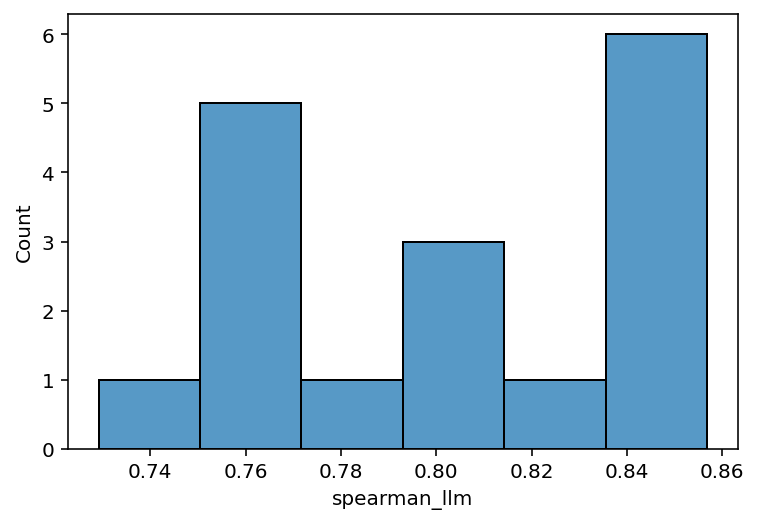

In [16]:
sns.histplot(data = df_correlations_llm, x = "spearman_llm")

In [17]:
df_correlations_llm.to_csv("../../data/processed/gc_llm_corrs.csv", index = False)

## Step 3: Individual human comparison

### Calculate LLM correlations per subject

In [18]:
participants = list(set(df_target['participant']))
ppt_lists = df_target[['participant', 'list']].drop_duplicates().values

In [19]:
correlations_ppt = []
for ppt, list_num in tqdm(ppt_lists):
    
    ### Get just that ppt
    df_tmp = df_target[df_target['participant'] == ppt]
    
    ### List
    df_list = list_to_df[list_num]
    
    ### Join with appropriate list
    df_joined_tmp = pd.merge(df_tmp, df_list)
    
    correlations_ppt.append({
        'ppt': ppt,
        'list_num': list_num,
        'n': len(df_joined_tmp),
        'pearson_ppt': ss.pearsonr(df_joined_tmp['Response'],
                             df_joined_tmp['Concreteness.M'])[0],
        'spearman_ppt': ss.spearmanr(df_joined_tmp['Response'],
                             df_joined_tmp['Concreteness.M'])[0]
        
    })

100%|████████████████████████████████████████| 194/194 [00:00<00:00, 740.36it/s]


In [20]:
df_correlations_ppt = pd.DataFrame(correlations_ppt)
df_correlations_ppt.head(5)

,ppt,list_num,n,pearson_ppt,spearman_ppt
0,9443676.0,16.0,51,-0.161856,-0.127915
1,9443711.0,16.0,51,0.836610,0.825687
2,9443739.0,16.0,51,-0.031291,-0.011844
3,9443719.0,16.0,51,0.854053,0.845444
4,9443806.0,16.0,51,0.113551,0.219892


### Exclude low-performing humans

In [21]:
exclude = df_correlations_ppt[df_correlations_ppt['pearson_ppt'] < .1]['ppt'].values
len(exclude)

13

In [22]:
df_target = df_target[~df_target['participant'].isin(exclude)]

In [23]:
df_correlations_ppt = df_correlations_ppt[df_correlations_ppt['pearson_ppt'] >= .1]
print("{X} ppts after excluding ppts with low correlations.".format(X = df_correlations_ppt.shape[0]))

181 ppts after excluding ppts with low correlations.


### Individual humans vs. LLM

In [24]:
df_individual_comparison = pd.merge(df_correlations_ppt, df_correlations_llm)
df_individual_comparison['pearson_diff'] = df_individual_comparison['pearson_llm'] - df_individual_comparison['pearson_ppt']
df_individual_comparison['spearman_diff'] = df_individual_comparison['spearman_llm'] - df_individual_comparison['spearman_ppt']

In [26]:
print("Average pearson's r across lists: {r}".
     format(r = df_individual_comparison['pearson_ppt'].mean()))
print("Average Spearman's rho across lists: {r}".
     format(r = df_individual_comparison['spearman_ppt'].mean()))

Average pearson's r across lists: 0.6710832162599336
Average Spearman's rho across lists: 0.674907221617292


In [29]:
print("SD pearson's r across lists: {r}".
     format(r = df_individual_comparison['pearson_ppt'].std()))
print("SD Spearman's rho across lists: {r}".
     format(r = df_individual_comparison['spearman_ppt'].std()))

SD pearson's r across lists: 0.2020870981461037
SD Spearman's rho across lists: 0.2012365708240787


In [30]:
print("Average difference in Pearson's r (LLM - Human) across lists: {r}".
     format(r = df_individual_comparison['pearson_diff'].mean()))
print("Average difference in Spearman's rho across lists: {r}".
     format(r = df_individual_comparison['spearman_diff'].mean()))

Average difference in Pearson's r (LLM - Human) across lists: 0.1230418227898329
Average difference in Spearman's rho across lists: 0.12658152516579635


In [34]:
### Percentile
df_filtered = df_individual_comparison[df_individual_comparison['spearman_ppt']>=df_individual_comparison['spearman_llm'].mean()]
print(len(df_filtered)/len(df_individual_comparison))
print(1 - len(df_filtered)/len(df_individual_comparison))

0.2983425414364641
0.7016574585635359


Text(0.5, 0, "Distribution of human Pearson's correlations")

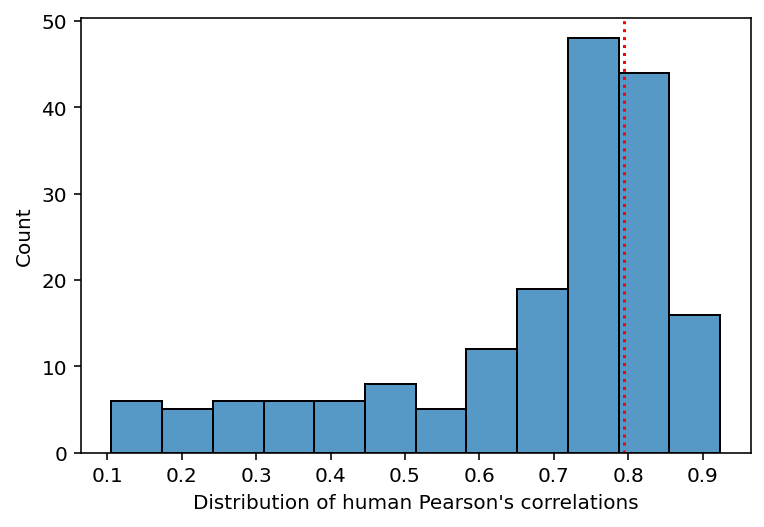

In [31]:
sns.histplot(data = df_individual_comparison,
            x = "pearson_ppt")
plt.axvline(x = df_individual_comparison['pearson_llm'].mean(), linestyle = "dotted", color = "red")
plt.xlabel("Distribution of human Pearson's correlations")

Text(0.5, 0, 'Distribution of human Spearman correlations')

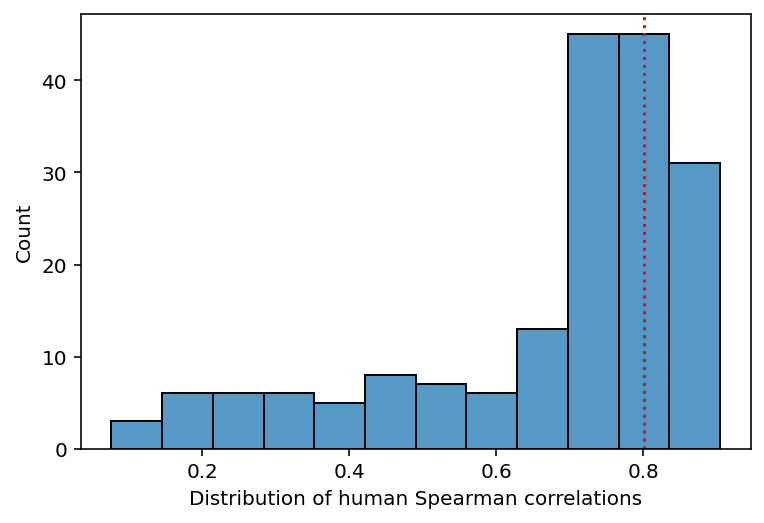

In [32]:
sns.histplot(data = df_individual_comparison,
            x = "spearman_ppt")
plt.axvline(x = df_individual_comparison['spearman_llm'].mean(), linestyle = "dotted", color = "red")
plt.xlabel("Distribution of human Spearman correlations")

## Step 4: Sampling comparison

In this crucial step, we ask about **how many participants** are needed to attain the same degree of correlation with the ground truth as GPT-4 has. 

For each list, we:

- Sample random subsets of ppts of size $k$.  
- Compute the average rating per word for each subset.  
- Compute the correlation between this **sample** and the ground truth.  
- Repeat for larger and larger values of $k$.

In [47]:
### For reproducibility during sampling
random.seed(1)
MAX_COMBOS = 500

In [48]:
### Track correlations
correlations_ppt_sample = []
for LIST in tqdm(list(range(1, 18))):

    ### Target list
    df_target_list = df_target[df_target['list'] == LIST]
    ## Ppts
    ppts = df_target_list['participant'].unique()
    
    ### In future, set K higher
    for K in range(1, len(ppts)):

        ### Unique combinations of size K
        combinations = list(itertools.combinations(ppts, K))
        
        ### To make analysis easier, 
        if len(combinations) > MAX_COMBOS:
            combinations = random.sample(combinations, MAX_COMBOS)

        ## Target df
        df_true = list_to_df[LIST]

        for i, combo in enumerate(combinations):

            df_tmp = df_target_list[df_target_list['participant'].isin(combo)]

            ## Get sample avg
            df_tmp_avg = df_tmp[['word', 'Response']].groupby('word').mean().reset_index()

            ## Join with target_list
            df_joined_tmp = pd.merge(df_tmp_avg, df_true)

            correlations_ppt_sample.append({
                'k': K,
                'combo_index': i,
                'list_num': LIST,
                'n': len(df_joined_tmp),
                'pearson_k': ss.pearsonr(df_joined_tmp['Response'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'spearman_k': ss.spearmanr(df_joined_tmp['Response'],
                                     df_joined_tmp['Concreteness.M'])[0]

            })

100%|███████████████████████████████████████████| 17/17 [01:02<00:00,  3.65s/it]


In [49]:
df_correlations_ppt_sample = pd.DataFrame(correlations_ppt_sample)
df_correlations_ppt_sample.shape

(33214, 6)

In [50]:
### Merge with LLMs
df_subset_comparison = pd.merge(df_correlations_ppt_sample, df_correlations_llm)
df_subset_comparison['pearson_diff'] = df_subset_comparison['pearson_llm'] - df_subset_comparison['pearson_k']
df_subset_comparison['spearman_diff'] = df_subset_comparison['spearman_llm'] - df_subset_comparison['spearman_k']

In [51]:
print("Average difference in Pearson's r across lists: {r}".
     format(r = df_subset_comparison['pearson_diff'].mean()))
print("Average difference in Spearman's rho across lists: {r}".
     format(r = df_subset_comparison['spearman_diff'].mean()))

Average difference in Pearson's r across lists: -0.08341128522574881
Average difference in Spearman's rho across lists: -0.0778183239731561


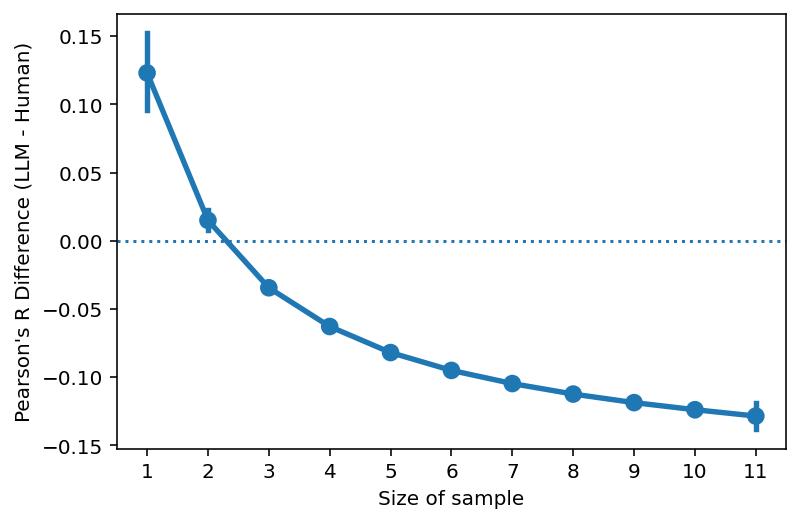

In [52]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'pearson_diff')
plt.xlabel("Size of sample")
plt.ylabel("Pearson's R Difference (LLM - Human)")
plt.axhline(y = 0, linestyle = "dotted")


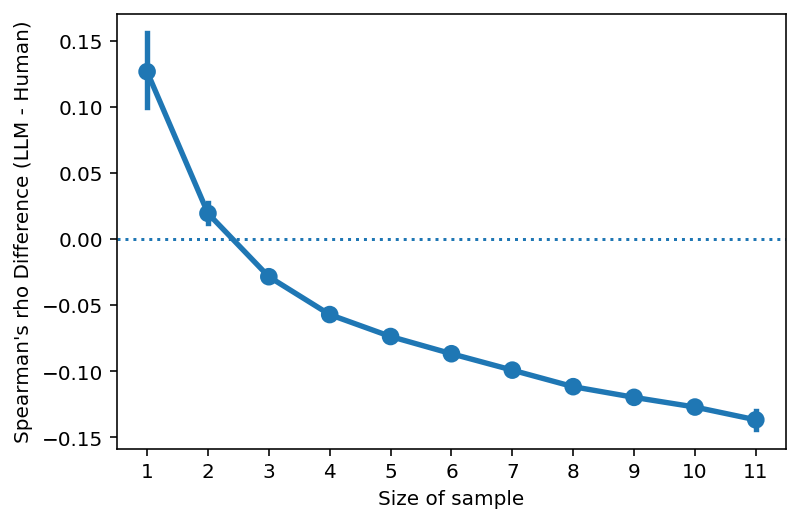

In [53]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'spearman_diff')
plt.xlabel("Size of sample")
plt.ylabel("Spearman's rho Difference (LLM - Human)")
plt.axhline(y = 0, linestyle = "dotted")

In [54]:
### Merge with LLMs
df_subset_comparison['pearson_rat'] = df_subset_comparison['pearson_llm'] / df_subset_comparison['pearson_k']
df_subset_comparison['spearman_rat'] = df_subset_comparison['spearman_llm'] / df_subset_comparison['spearman_k']

In [55]:
print("Average ratio in Pearson's r across lists: {r}".
     format(r = df_subset_comparison['pearson_rat'].mean()))
print("Average ratio in Spearman's rho across lists: {r}".
     format(r = df_subset_comparison['spearman_rat'].mean()))

Average ratio in Pearson's r across lists: 0.9113880511102153
Average ratio in Spearman's rho across lists: 0.9172945644955264


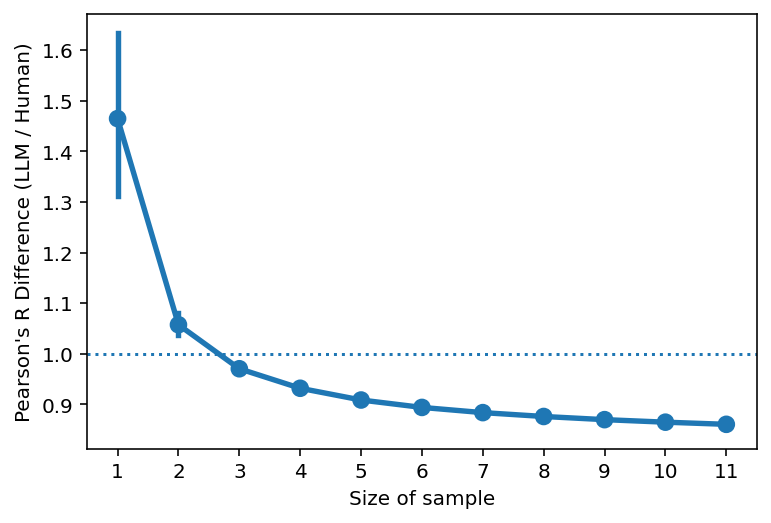

In [56]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'pearson_rat')
plt.xlabel("Size of sample")
plt.ylabel("Pearson's R Difference (LLM / Human)")
plt.axhline(y = 1, linestyle = "dotted")


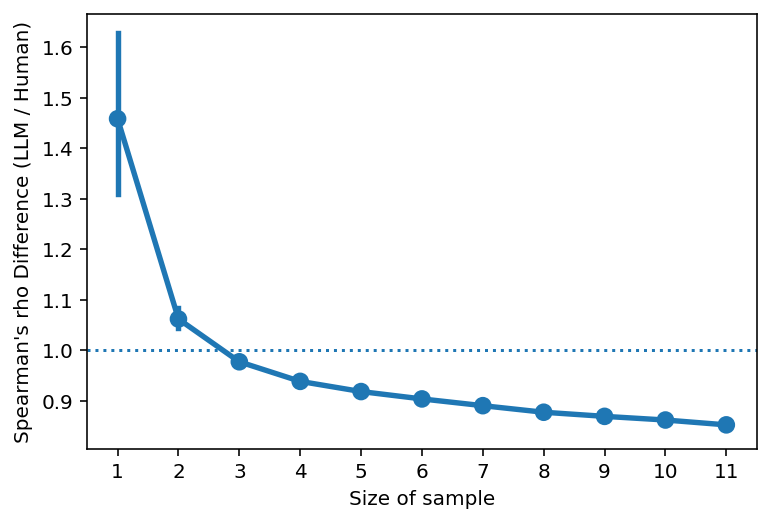

In [57]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'spearman_rat')
plt.xlabel("Size of sample")
plt.ylabel("Spearman's rho Difference (LLM / Human)")
plt.axhline(y = 1, linestyle = "dotted")

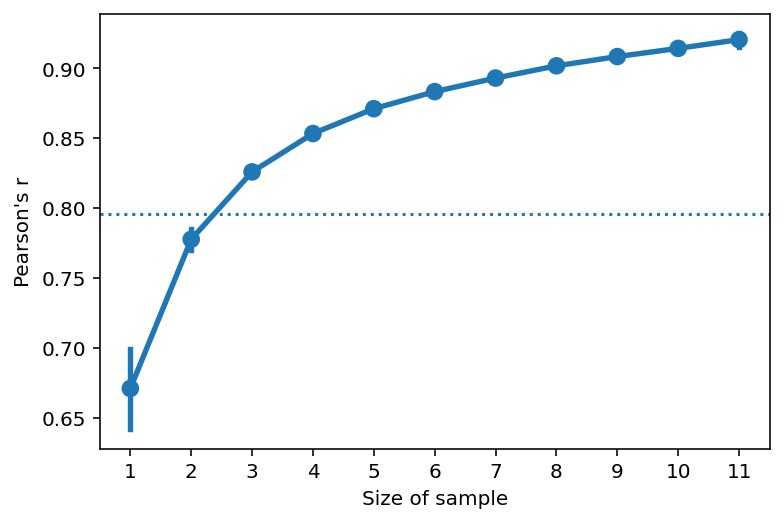

In [58]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'pearson_k')
plt.xlabel("Size of sample")
plt.ylabel("Pearson's r")
plt.axhline(y = df_correlations_llm['pearson_llm'].mean(), linestyle = "dotted")

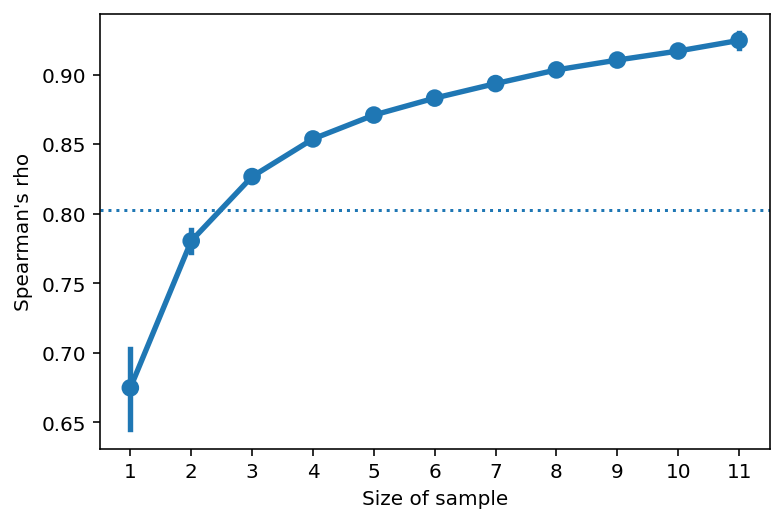

In [59]:
sns.pointplot(data = df_subset_comparison,
            x = "k", y = 'spearman_k')
plt.xlabel("Size of sample")
plt.ylabel("Spearman's rho")
plt.axhline(y = df_correlations_llm['spearman_llm'].mean(), linestyle = "dotted")

### Parity Analysis

Here, we ask at what point the distribution of differences (or ratios) is significantly less than 0 (or 1, for raitos).

#### Ratio

In [65]:
parity_results_ratio = []
for k in range(1, max(df_subset_comparison['k'])):
    
    ## Get subsets of size K
    df_tmp = df_subset_comparison[df_subset_comparison['k'] == k]
    
    ## Get Pearson's ratios
    values = df_tmp['pearson_rat']
    
    ## one-tailed t-test
    t_stat, p_value = ss.ttest_1samp(values, 1)
    
    parity_results_ratio.append({
        'k': k,
        't': t_stat,
        'p': p_value / 2, ## For one-tailed test
        'n': len(values),
        'mean': values.mean(),
        'sd': values.std()
    })

In [67]:
df_parity_results_ratio = pd.DataFrame(parity_results_ratio)
df_parity_results_ratio_sig = df_parity_results_ratio[(df_parity_results_ratio['p']<.05)&(df_parity_results_ratio['t']<0)]
df_parity_results_ratio_sig['k'].min()
# Find the index of the row with the minimum value in column B
idx = df_parity_results_ratio_sig['k'].idxmin()
# Retrieve the row by index
min_row = df_parity_results_ratio_sig.loc[idx]
print("Minimum k: {k}, t({df}) = {t}, p = {p}, mean = {mean}".
     format(k = min_row['k'],
            df = min_row['n'] - 1,
           t = min_row['t'],
           p = min_row['p'],
           mean = min_row['mean']))

Minimum k: 3.0, t(2688.0) = -11.228076616830348, p = 6.36843021055061e-29, mean = 0.9705081653352217


In [69]:
parity_results_ratio = []
for k in range(1, max(df_subset_comparison['k'])):
    
    ## Get subsets of size K
    df_tmp = df_subset_comparison[df_subset_comparison['k'] == k]
    
    ## Get Pearson's ratios
    values = df_tmp['spearman_rat']
    
    ## one-tailed t-test
    t_stat, p_value = ss.ttest_1samp(values, 1)
    
    parity_results_ratio.append({
        'k': k,
        't': t_stat,
                'n': len(values),
        'p': p_value / 2, ## For one-tailed test
        'mean': values.mean(),
        'sd': values.std()
    })

In [70]:
df_parity_results_ratio = pd.DataFrame(parity_results_ratio)
df_parity_results_ratio_sig = df_parity_results_ratio[(df_parity_results_ratio['p']<.05)&(df_parity_results_ratio['t']<0)]
df_parity_results_ratio_sig['k'].min()
# Find the index of the row with the minimum value in column B
idx = df_parity_results_ratio_sig['k'].idxmin()
# Retrieve the row by index
min_row = df_parity_results_ratio_sig.loc[idx]
print("Minimum k: {k}, t({df}) = {t}, p = {p}, mean = {mean}".
     format(k = min_row['k'],
            df = min_row['n'] - 1,
           t = min_row['t'],
           p = min_row['p'],
           mean = min_row['mean']))

Minimum k: 3.0, t(2688.0) = -9.46124963898463, p = 3.206090764208409e-21, mean = 0.9767849910886853


#### Difference

In [191]:
parity_results_diff = []
for k in range(1, max(df_subset_comparison['k'])):
    
    ## Get subsets of size K
    df_tmp = df_subset_comparison[df_subset_comparison['k'] == k]
    
    ## Get Pearson's ratios
    values = df_tmp['pearson_diff']
    
    ## one-tailed t-test
    t_stat, p_value = ss.ttest_1samp(values, 0)
    
    parity_results_diff.append({
        'k': k,
        't': t_stat,
        'p': p_value / 2, ## For one-tailed test
        'mean': values.mean(),
        'sd': values.std()
    })

In [193]:
df_parity_results_diff = pd.DataFrame(parity_results_diff)
df_parity_results_diff_sig = df_parity_results_diff[(df_parity_results_diff['p']<.05)&(df_parity_results_diff['t']<0)]
df_parity_results_diff_sig['k'].min()
# Find the index of the row with the minimum value in column B
idx = df_parity_results_diff_sig['k'].idxmin()
# Retrieve the row by index
min_row = df_parity_results_diff_sig.loc[idx]
print("Minimum k: {k}, t = {t}, p = {p}, mean = {mean}".
     format(k = min_row['k'],
           t = min_row['t'],
           p = min_row['p'],
           mean = min_row['mean']))

Minimum k: 3.0, t = -21.59355707813691, p = 8.53188699349451e-96, mean = -0.03446863803719565


In [194]:
parity_results_diff = []
for k in range(1, max(df_subset_comparison['k'])):
    
    ## Get subsets of size K
    df_tmp = df_subset_comparison[df_subset_comparison['k'] == k]
    
    ## Get Pearson's ratios
    values = df_tmp['spearman_diff']
    
    ## one-tailed t-test
    t_stat, p_value = ss.ttest_1samp(values, 0)
    
    parity_results_diff.append({
        'k': k,
        't': t_stat,
        'p': p_value / 2, ## For one-tailed test
        'mean': values.mean(),
        'sd': values.std()
    })

In [195]:
df_parity_results_diff = pd.DataFrame(parity_results_diff)
df_parity_results_diff_sig = df_parity_results_diff[(df_parity_results_diff['p']<.05)&(df_parity_results_diff['t']<0)]
df_parity_results_diff_sig['k'].min()
# Find the index of the row with the minimum value in column B
idx = df_parity_results_diff_sig['k'].idxmin()
# Retrieve the row by index
min_row = df_parity_results_diff_sig.loc[idx]
print("Minimum k: {k}, t = {t}, p = {p}, mean = {mean}".
     format(k = min_row['k'],
           t = min_row['t'],
           p = min_row['p'],
           mean = min_row['mean']))

Minimum k: 3.0, t = -18.80777771860262, p = 1.550394593546921e-74, mean = -0.02845326534599594


## Step 6: Centaur method

In this step, we ask about **augmenting** human samples with LLM judgments. That is: if LLM judgments are "worth more" than individual human judgments (in terms of correlation with the ground truth), then how much can we improve our precision by combining judgment types?

Here, we can compare this measure to:

- The maximum correlation achievable, i.e., using all humans in a given sample.  
- The correlation achieved using an LLM alone.  
- The correlation achieved using only humans from a given sample of size $K$. 

Of course, there are multiple ways one could combine LLM judgments. 

I consider two approaches:

- Taking the average of LLM ratings and the human sample mean. This **over-weights** LLM judgments in the resulting estimate, but is a more useful proxy for researchers who (for whatever reason) lack access to individual human ratings.
- Including LLM ratings as "participants" in the estimate of the human sample mean. This gives LLM ratings the **same weight as individual human ratings**. 

Note that neither approach is necessarily *ideal*: it is possible that for a given task and LLM, there is a more **optimal mixing** of ratings.

### Get max correlations (using all ppts in a list)

In [72]:
### First, get all the `max_corr` values
max_corrs = []
for list_num in range(1, 18):
    
    ## Target df
    df_true = list_to_df[list_num]
    
    ### Target list
    df_target_list = df_target[df_target['list'] == list_num]
    
    if len(df_target_list) > 0:

        ## Get avg
        df_tmp_avg = df_target_list[['word', 'Response']].groupby('word').mean().reset_index()

        ## Join
        df_joined_tmp = pd.merge(df_tmp_avg, df_true)

        max_corrs.append({
            'list_num': list_num,
            'num_ppts': len(df_target_list['participant'].unique()),
            'pearson_max': ss.pearsonr(df_joined_tmp['Response'],
                                 df_joined_tmp['Concreteness.M'])[0],
            'spearman_max': ss.spearmanr(df_joined_tmp['Response'],
                                 df_joined_tmp['Concreteness.M'])[0]
        })

In [73]:
df_max_corrs = pd.DataFrame(max_corrs)
df_max_corrs.head(2)

,list_num,num_ppts,pearson_max,spearman_max
0,1,7,0.928279,0.928080
1,2,10,0.905158,0.916618


<AxesSubplot:xlabel='pearson_max', ylabel='Count'>

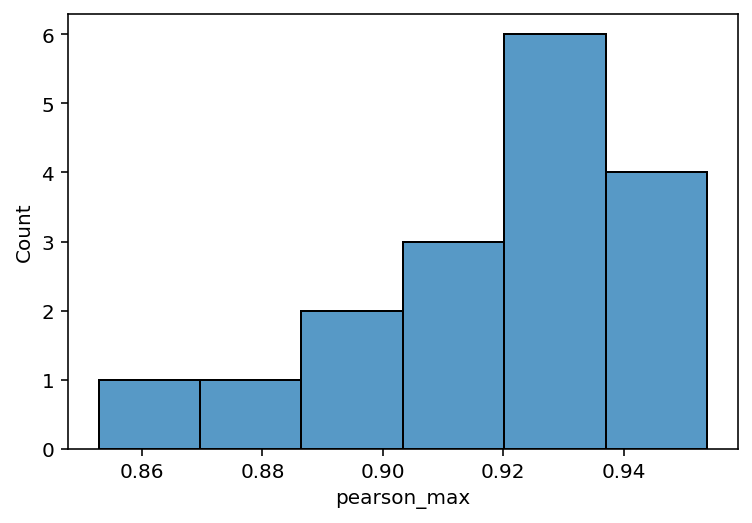

In [74]:
sns.histplot(data = df_max_corrs, x = "pearson_max")

In [75]:
df_max_corrs.to_csv("../../data/processed/gc_max_corrs.csv", index = False)

### Get centaur correlations

In [240]:
### For reproducibility during sampling
random.seed(1)
MAX_COMBOS = 500

In [253]:
### Track correlations
correlations_ppt_centaur = []
for LIST in tqdm(list(range(1, 18))):

    ### Target list
    df_target_list = df_target[df_target['list'] == LIST]
    ## Ppts
    ppts = df_target_list['participant'].unique()
    
    ### In future, set K higher
    for K in range(1, len(ppts)):

        ### Unique combinations of size K
        combinations = list(itertools.combinations(ppts, K))
        
        ### To make analysis easier, 
        if len(combinations) > MAX_COMBOS:
            combinations = random.sample(combinations, MAX_COMBOS)

        ## Target df
        df_true = list_to_df[LIST]

        for i, combo in enumerate(combinations):

            df_tmp = df_target_list[df_target_list['participant'].isin(combo)][['participant', 'word', 'Response']]

            ## Get sample avg
            df_tmp_avg = df_tmp[['word', 'Response']].groupby('word').mean().reset_index()
            
            ## Create centaur DF
            df_llm_tmp = df_true[['word', 'Concreteness']].copy()
            df_llm_tmp['participant'] = 'LLM'
            df_llm_tmp['Response'] = df_llm_tmp['Concreteness']
            df_llm_tmp = df_llm_tmp[['word', 'Response', 'participant']]
            df_centaur = pd.concat([df_tmp, df_llm_tmp])
            
            ## Get centaur avg
            df_centaur_avg = df_centaur[['word', 'Response']].groupby('word').mean().reset_index()

            ## Join with target_list
            df_joined_tmp = pd.merge(df_tmp_avg, df_true)
            
            ## Join with target_list
            df_joined_tmp_centaur = pd.merge(df_centaur_avg, df_true)
            
            ## Centaur approach 1
            df_joined_tmp['Concreteness_augmented'] = (df_joined_tmp['Response'] + df_joined_tmp['Concreteness']) / 2

            correlations_ppt_centaur.append({
                'k': K,
                'combo_index': i,
                'list_num': LIST,
                'n': len(df_joined_tmp),
                'pearson_centaur1': ss.pearsonr(df_joined_tmp['Concreteness_augmented'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'spearman_centaur1': ss.spearmanr(df_joined_tmp['Concreteness_augmented'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'pearson_ppt': ss.pearsonr(df_joined_tmp['Response'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'spearman_ppt': ss.spearmanr(df_joined_tmp['Response'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'pearson_centaur2': ss.pearsonr(df_joined_tmp_centaur['Response'],
                                     df_joined_tmp['Concreteness.M'])[0],
                'spearman_centaur2': ss.spearmanr(df_joined_tmp_centaur['Response'],
                                     df_joined_tmp['Concreteness.M'])[0],

            })

100%|███████████████████████████████████████████| 17/17 [03:05<00:00, 10.93s/it]


In [254]:
df_correlations_ppt_centaur = pd.DataFrame(correlations_ppt_centaur)
df_correlations_ppt_centaur.shape

(33214, 10)

In [255]:
df_correlations_ppt_centaur.head(5)

,k,combo_index,list_num,n,pearson_centaur1,spearman_centaur1,pearson_ppt,spearman_ppt,pearson_centaur2,spearman_centaur2
0,1,0,1,51,0.868795,0.853799,0.816264,0.785484,0.868795,0.853799
1,1,1,1,51,0.827181,0.825678,0.739995,0.760308,0.827181,0.825678
2,1,2,1,51,0.876710,0.854323,0.787459,0.740725,0.876710,0.854323
3,1,3,1,51,0.852146,0.826818,0.775153,0.755819,0.852146,0.826818
4,1,4,1,51,0.851702,0.835127,0.816165,0.830323,0.851702,0.835127


### Get centaur correlations

In [256]:
df_centaur_with_llm = pd.merge(df_correlations_ppt_centaur,
                              df_correlations_llm)
df_centaur_with_llm.shape

(33214, 12)

In [257]:
df_centaur_with_llm = pd.merge(df_centaur_with_llm,
                              df_max_corrs, how = "left")
df_centaur_with_llm.shape

(33214, 15)

### Comparison on a single plot

In [282]:
df_centaur_with_llm.shape

(33214, 15)

In [283]:
melted_df = pd.melt(
    df_centaur_with_llm,
    id_vars=['k', 'combo_index', 'list_num', 'n'],  # columns to keep
    value_vars=['pearson_centaur1', 'pearson_centaur2', 'pearson_ppt'],  # columns to melt
    var_name='pearson_type',  # new column name for melted columns
    value_name='pearson_correlation'  # new column name for values
)

In [284]:
melted_df['Sample Type'] = melted_df['pearson_type'].str.replace('pearson_', '')

Text(0, 0.5, 'Correlation with ground truth')

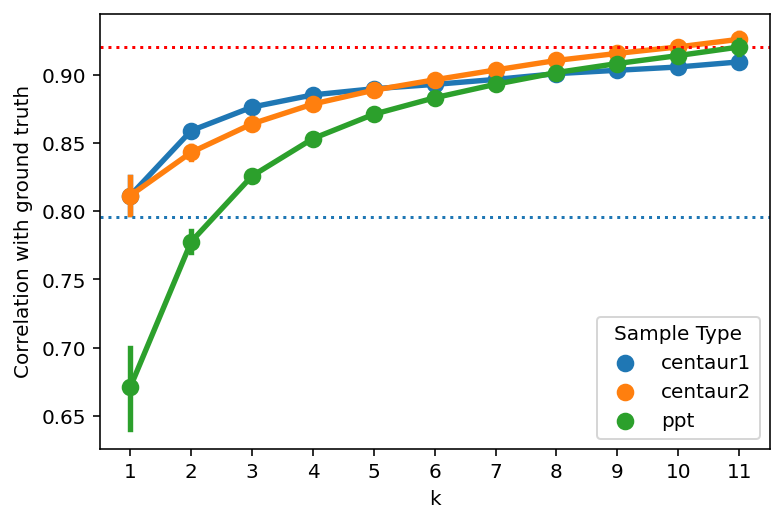

In [285]:
sns.pointplot(data = melted_df,
            x = "k",
            y = "pearson_correlation",
             hue = "Sample Type")

plt.axhline(y = df_correlations_llm['pearson_llm'].mean(), linestyle = "dotted")
plt.axhline(y = df_max_corrs['pearson_max'].mean(), linestyle = "dotted", color = "red")

plt.ylabel("Correlation with ground truth")

In [286]:
melted_df = pd.melt(
    df_centaur_with_llm,
    id_vars=['k', 'combo_index', 'list_num', 'n'],  # columns to keep
    value_vars=['spearman_centaur1', 'spearman_centaur2', 'spearman_ppt'],  # columns to melt
    var_name='spearman_type',  # new column name for melted columns
    value_name='spearman_correlation'  # new column name for values
)

In [287]:
melted_df['Sample Type'] = melted_df['spearman_type'].str.replace('spearman_', '')

Text(0.5, 0, 'Sample Size')

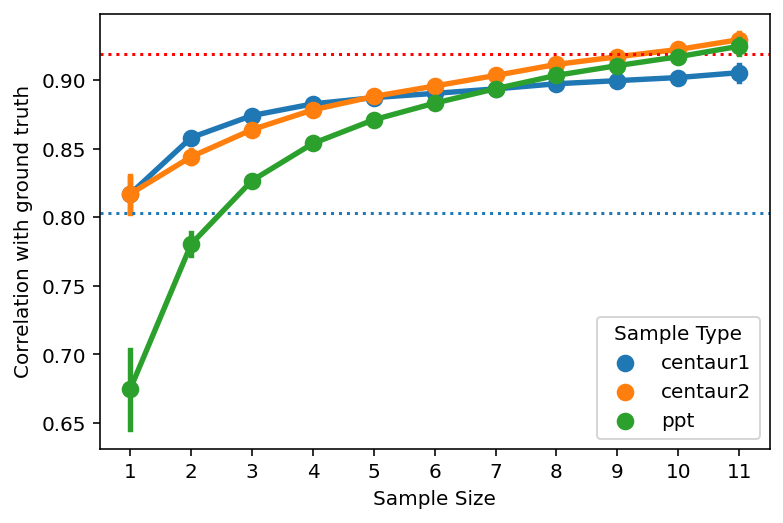

In [288]:
sns.pointplot(data = melted_df,
            x = "k",
            y = "spearman_correlation",
             hue = "Sample Type")

plt.axhline(y = df_correlations_llm['spearman_llm'].mean(), linestyle = "dotted")
plt.axhline(y = df_max_corrs['spearman_max'].mean(), linestyle = "dotted", color = "red")
plt.ylabel("Correlation with ground truth")
plt.xlabel("Sample Size")

Text(0.5, 0, 'Sample Size')

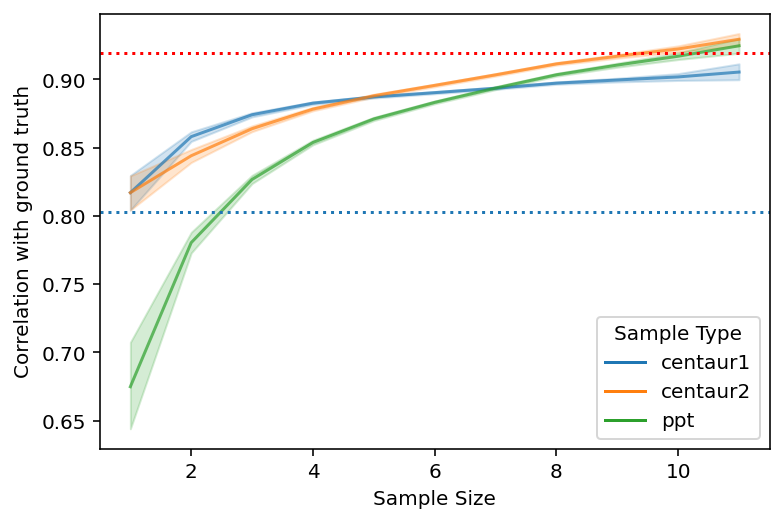

In [289]:
sns.lineplot(data = melted_df,
            x = "k",
            y = "spearman_correlation",
             hue = "Sample Type",
            alpha = .7)

plt.axhline(y = df_correlations_llm['spearman_llm'].mean(), linestyle = "dotted")
plt.axhline(y = df_max_corrs['spearman_max'].mean(), linestyle = "dotted", color = "red")
plt.ylabel("Correlation with ground truth")
plt.xlabel("Sample Size")

In [274]:
### Save data
df_centaur_with_llm.to_csv("../../data/processed/gc_results.csv", index = False)